In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
trans_df = pd.read_csv('/Users/mehrnazuser/Documents/Lavoro/BlueRock Logistics/Data/Trans_BLR.csv', usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], sep =';', encoding = 'utf-8')
#Type_List = ['COL', 'RET']
#trans_df = trans_df.loc[trans_df['T_DOC_TYPE'].isin(Type_List)]
trans_df = trans_df.loc[trans_df['T_DOC_TYPE'] == 'COL']

trans_df['T_EFFECTIVE_DATE'] = pd.to_datetime(trans_df['T_EFFECTIVE_DATE'])
trans_df['Date'] = trans_df.apply(lambda r:r['T_EFFECTIVE_DATE'].date(), axis = 1)
trans_df = trans_df.dropna(subset = ['Date'])

trans_df = trans_df[['Date', 'T_DOC_TYPE', 'T_SENDING_ID', 'T_RTI_NAME', 'T_ACT_HAND_OUT_QTY']]
trans_df = trans_df.reset_index()
trans_df = trans_df.drop('index', axis = 1)
#trans_df.head()

In [3]:
depot_add = pd.read_excel('/Users/mehrnazuser/Documents/Lavoro/BlueRock Logistics/Data/masterdata20190918.xlsx', sheet_name = 'Depot Account_Addreses')
depot_add = depot_add[['name', 'code', 'country']]
#depot_add.head()

In [4]:
# JOIN

trans_full = trans_df.join(depot_add.set_index('code'), on = 'T_SENDING_ID')
trans_full = trans_full.drop(['T_SENDING_ID', 'T_DOC_TYPE'], axis =1)
trans_full.head()

,Date,T_RTI_NAME,T_ACT_HAND_OUT_QTY,name,country
0,2014-12-22,CC Euro Container Base,60,NL-Bleiswijk-CCNL,NL
1,2014-12-22,CC Euro Container Post 170,240,NL-Bleiswijk-CCNL,NL
2,2014-07-09,CC Container Base,4,NL-Bleiswijk Bloemenveiling Holland,NL
3,2014-07-09,CC Container Shelf,30,NL-Bleiswijk Bloemenveiling Holland,NL
4,2014-07-04,CC Container Base,4,NL-Bleiswijk Bloemenveiling Holland,NL


# Filter Dataset:

### _ONLY France

In [5]:

trans_it = trans_full.loc[trans_full['country'] == 'FR']
trans_it = trans_it.sort_values('Date', ascending = True)
trans_it = trans_it.drop(['country'], axis = 1)
trans_it.head()

,Date,T_RTI_NAME,T_ACT_HAND_OUT_QTY,name
8471,2014-09-25,CC Container Post 180,300,F-26 Lyon HortiTrace
8359,2014-09-25,CC Container Base,75,F-26 Lyon HortiTrace
15228,2014-10-02,CC Container Post 180,800,F-23 Montpellier HortiTrace
15274,2014-10-02,CC Container Base,200,F-23 Montpellier HortiTrace
15275,2014-10-02,CC Container Shelf,400,F-23 Montpellier HortiTrace


### _RTI = Container Base

In [6]:
it_cb = trans_it.loc[trans_it['T_RTI_NAME'] == 'CC Container Base']
it_cb = it_cb.drop(['T_RTI_NAME'], axis = 1)
it_cb['Date'] = pd.to_datetime(it_cb['Date'])
it_cb = it_cb.set_index('Date')
it_cb

,T_ACT_HAND_OUT_QTY,name
Date,,
2014-09-25,75,F-26 Lyon HortiTrace
2014-10-02,200,F-23 Montpellier HortiTrace
2014-10-03,120,F-26 Lyon HortiTrace
2014-10-06,40,F-24 Bordeaux HortiTrace
2014-10-07,187,F-28 Taule HortiTrace
...,...,...
2019-06-11,80,F-22 Angers HortiTrace
2019-06-13,170,F-29 Paris Sud Hortitrace
2019-06-14,13,F-29 Paris Sud Hortitrace


Text(0.5, 1.0, 'CB_IT Jul 2014--Jul 2019')

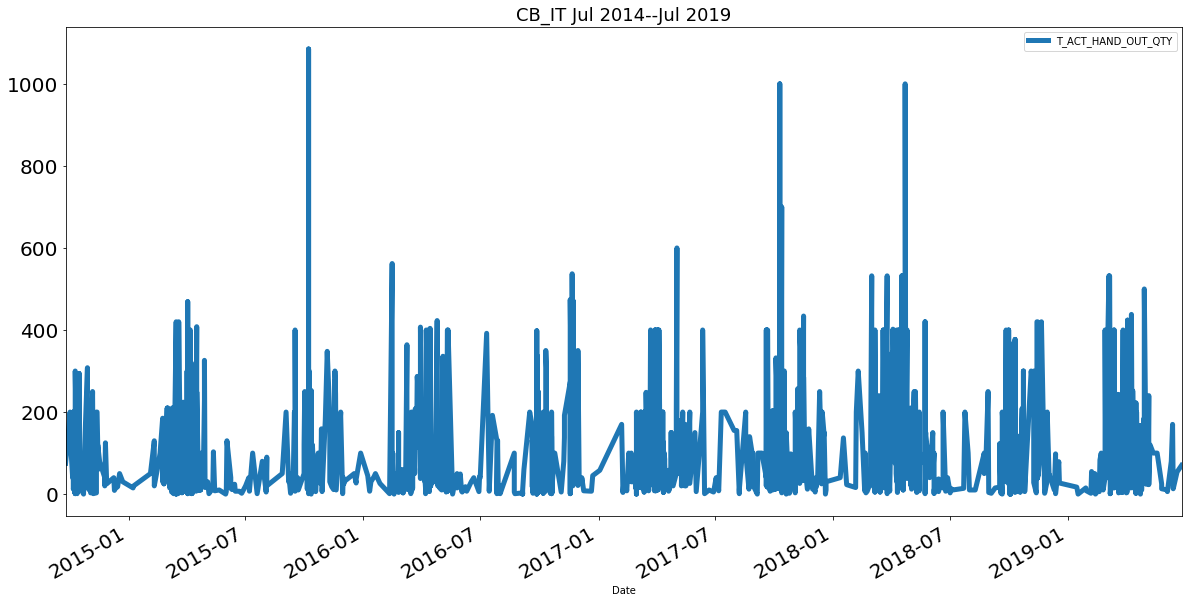

In [7]:
it_cb.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title("CB_IT Jul 2014--Jul 2019", fontsize = 18)

## Monthly from 2017 on

Text(0.5, 1.0, 'CB_IT : Jan 2017--Jul 2019')

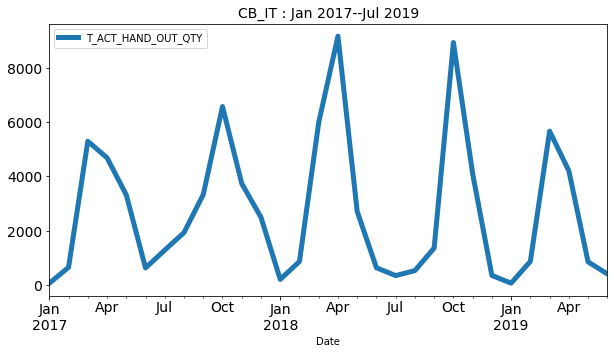

In [8]:
import datetime
it_cbm = it_cb.resample('1M').sum()
it_cb_m = it_cbm[(it_cbm.index >= datetime.datetime(2017,1,31))]
it_cb_m.plot(figsize=(10,5), linewidth=5, fontsize=14)
plt.title("CB_IT : Jan 2017--Jul 2019", fontsize = 14)

## Seasonal Decompose 2017

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from chart_studio.plotly import plot_mpl
result = seasonal_decompose(it_cb_m, model='multiplicative')
#fig = result.plot()
#plot_mpl(fig)

Text(0.5, 1.0, 'Residual')

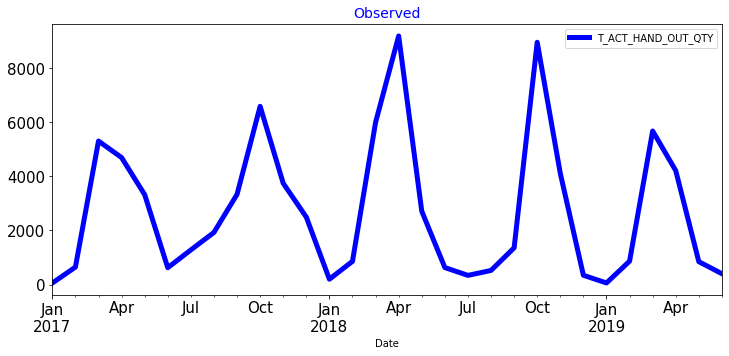

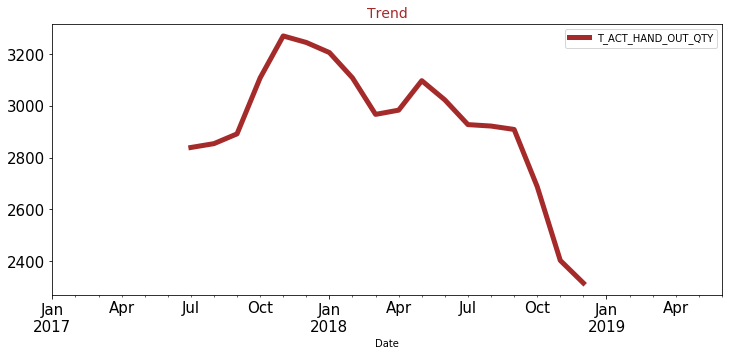

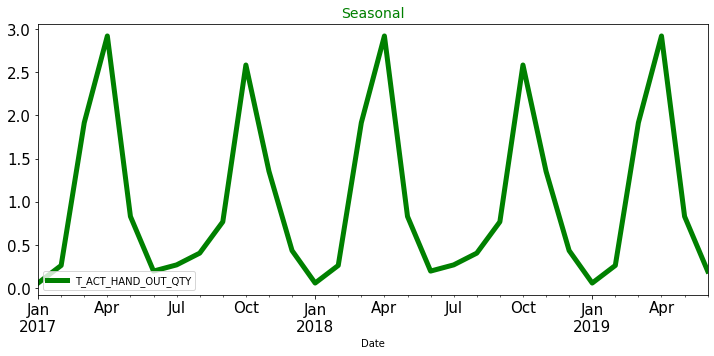

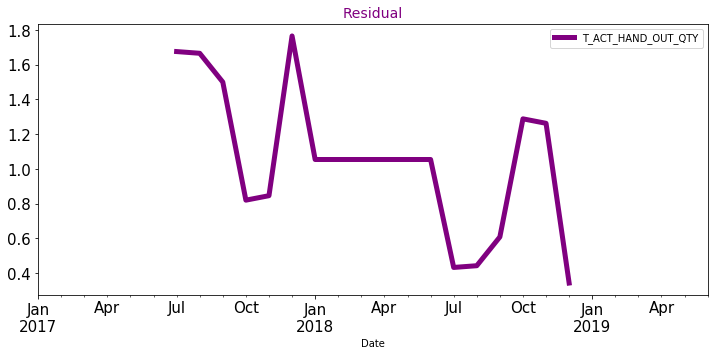

In [10]:
result.observed.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'blue')
plt.title('Observed', fontsize = 14, color ='blue')

result.trend.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'brown')
plt.title('Trend', fontsize = 14 , color = 'brown')

result.seasonal.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'green')
plt.title('Seasonal', fontsize = 14 , color = 'green')

result.resid.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'purple')
plt.title('Residual', fontsize = 14 , color = 'purple')

## SARIMA

In [11]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
stepwise_model = arima.auto_arima(it_cb_m, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=318.824, BIC=320.490, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=320.510, BIC=323.843, Fit time=0.067 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=316.828, BIC=317.661, Fit time=0.009 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=320.476, BIC=322.975, Fit time=0.031 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=318.511, BIC=321.010, Fit time=0.013 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=309.883, BIC=312.382, Fit

In [12]:
#it_cb_m.index

In [13]:
train = it_cb_m.loc['2017-01-31':'2018-12-31']
test = it_cb_m.loc['2019-01-31':]

In [14]:
model_fit = stepwise_model.fit(train)
model_fit

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [15]:
future_forecast = stepwise_model.predict(n_periods=6)
future_forecast

array([-1044.95345762,  -610.04015593,  4294.87314575,  7258.78644743,
         561.69974911, -1745.38694921])

Text(0.5, 1.0, '2019 Prediction of FR-CB')

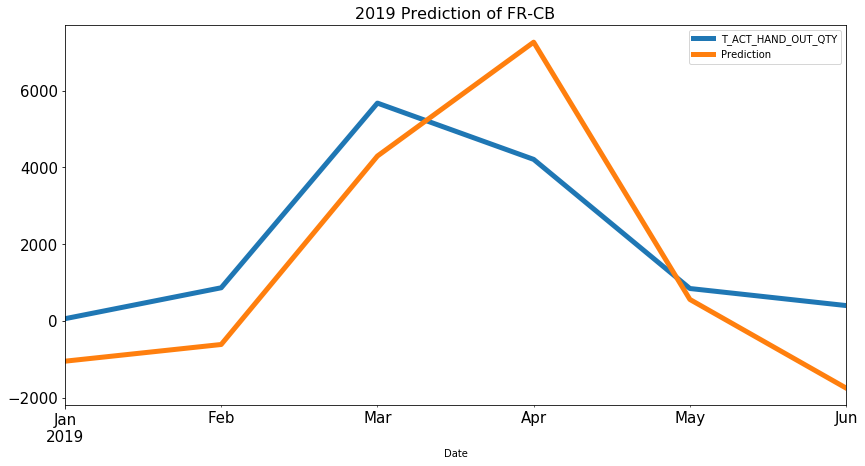

In [16]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).plot(figsize=(14,7), linewidth=5, fontsize=15)
plt.title('2019 Prediction of FR-CB', fontsize = 16)

In [17]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, future_forecast)
mse

3217553.647208595

In [18]:
model_fit.aic

<function pmdarima.arima.arima.ARIMA.aic(self)>

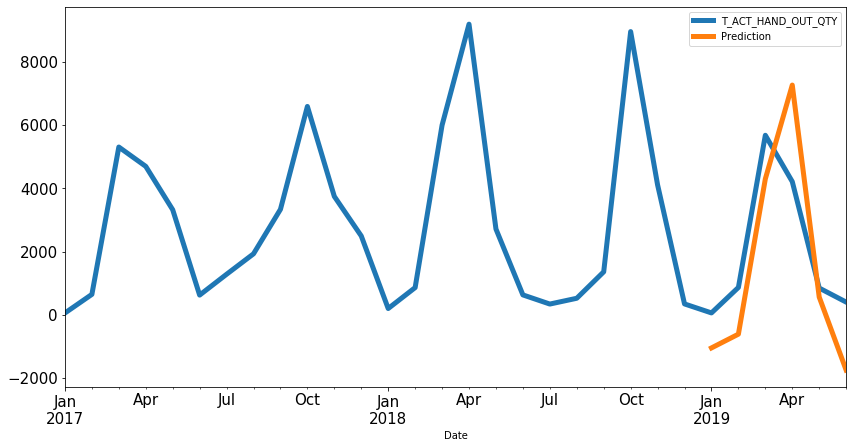

In [19]:
pd.concat([it_cb_m,future_forecast],axis=1).plot(figsize=(14,7), linewidth=5, fontsize=15)

## d&D = 0

In [20]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
nodiff_model = arima.auto_arima(it_cb_m, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(nodiff_model.aic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=560.725, BIC=563.527, Fit time=0.007 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=556.544, BIC=562.149, Fit time=0.035 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=580.879, BIC=582.281, Fit time=0.003 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=560.161, BIC=564.364, Fit time=0.010 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=557.944, BIC=564.950, Fit time=0.096 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=nan, BIC=nan, Fit time=na

In [21]:
nodiff_fit = nodiff_model.fit(train)

In [22]:
nondiff_forecast = nodiff_fit.predict(n_periods=6)
nondiff_forecast

array([2919.98223326, 3041.38263697, 3983.75097502, 4569.63189459,
       3381.15683798, 2998.95677728])

Text(0.5, 1.0, '2019 Prediction of FR-CB')

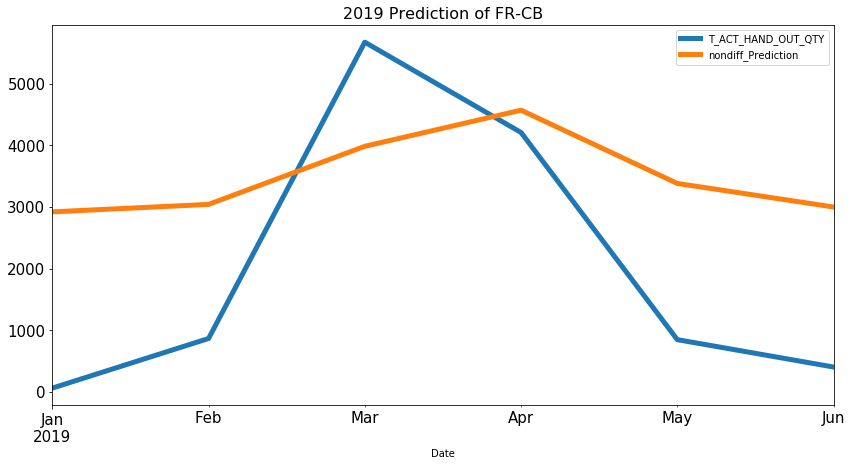

In [23]:
nondiff_forecast = pd.DataFrame(nondiff_forecast,index = test.index,columns=['nondiff_Prediction'])
pd.concat([test,nondiff_forecast],axis=1).plot(figsize=(14,7), linewidth=5, fontsize=15)
plt.title('2019 Prediction of FR-CB', fontsize = 16)

In [24]:
nondiff_mse = mean_squared_error(test, nondiff_forecast)
nondiff_mse

4841891.89865593

Text(0.5, 1.0, '2019 (non-diff) Prediction of FR-CB')

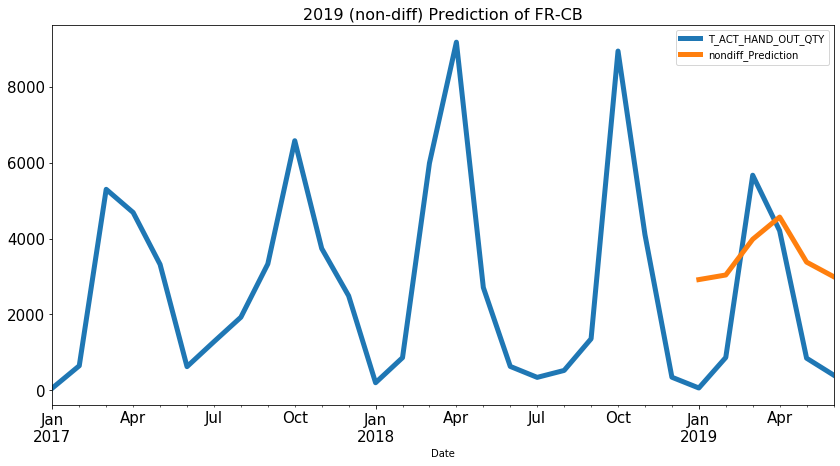

In [25]:
pd.concat([it_cb_m,nondiff_forecast],axis=1).plot(figsize=(14,7), linewidth=5, fontsize=15)
plt.title('2019 (non-diff) Prediction of FR-CB', fontsize = 16)

## Since Jul 2014 (all data, d&D = 2)

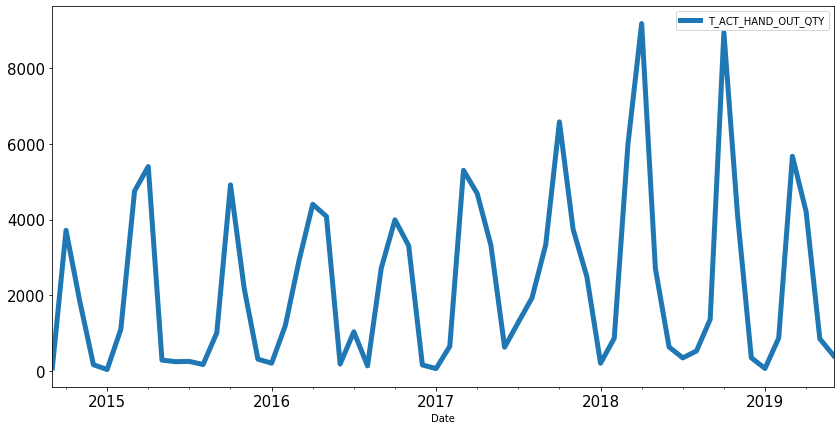

In [26]:
it_cbm.plot(figsize=(14,7), linewidth=5, fontsize=15)

In [27]:
all_model = arima.auto_arima(it_cb_m, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=2, D=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(all_model.aic())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 2, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 2, 0, 12); AIC=88.919, BIC=87.691, Fit time=0.015 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 2, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 2, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 2, 0, 12); AIC=87.070, BIC=86.456, Fit time=0.027 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 2, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 2, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 2, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 2, 0, 12); AIC=89.026, BIC=87.185, Fit time=0.034 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 2, 0, 12); AIC=nan, BIC=nan, Fit time=0.095 seconds
Fit ARIMA: ord

In [28]:
all_train = it_cb_m.loc['2014-07-31':'2018-12-31']
all_test = it_cb_m.loc['2019-01-31':]

In [29]:
all_fit = all_model.fit(all_train)

In [30]:
all_forecast = all_fit.predict(n_periods=6)
all_forecast

array([ -4824.95121951,  -5611.19512195,  -1522.43902439,   3949.31707317,
        -9141.92682927, -12127.17073171])

Text(0.5, 1.0, '2019 Prediction (with all data) of FR-CB')

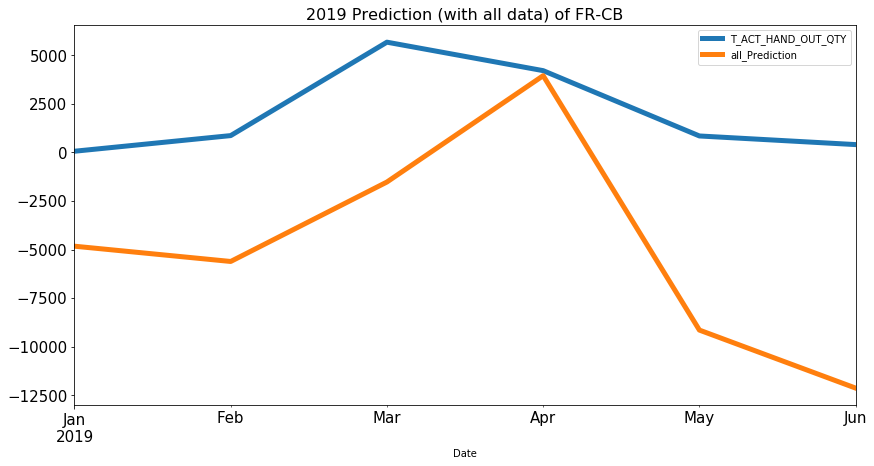

In [31]:
all_forecast = pd.DataFrame(all_forecast,index = test.index,columns=['all_Prediction'])
pd.concat([test,all_forecast],axis=1).plot(figsize=(14,7), linewidth=5, fontsize=15)
plt.title('2019 Prediction (with all data) of FR-CB', fontsize = 16)

In [32]:
all_mse = mean_squared_error(all_test, all_forecast)
all_mse

62408612.22397366

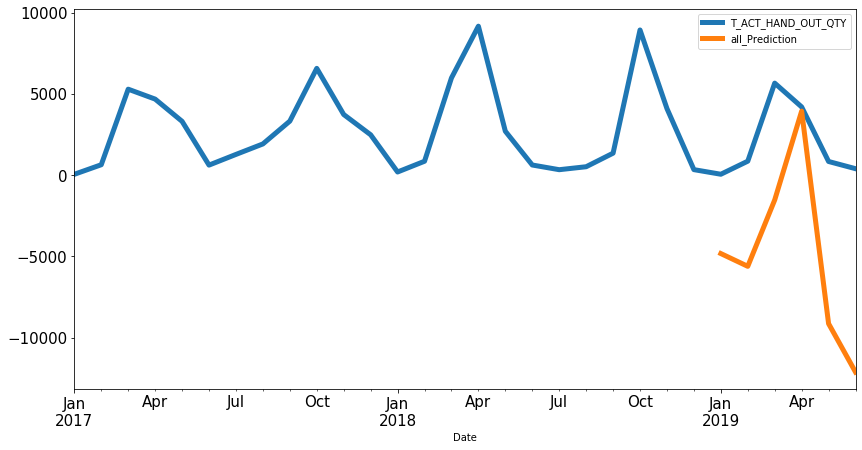

In [33]:
pd.concat([it_cb_m, all_forecast],axis=1).plot(figsize=(14,7), linewidth=5, fontsize=15)

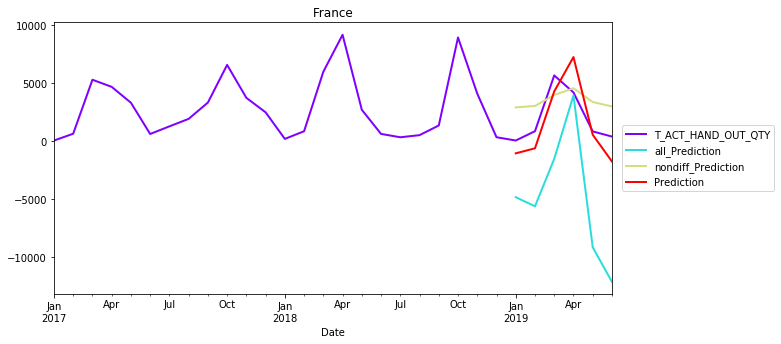

In [34]:
pd.concat([it_cb_m, all_forecast, nondiff_forecast, future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='France')
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.show()

In [35]:
MSEs = [mse, nondiff_mse, all_mse]

In [36]:
norm = [i/sum(MSEs) for i in MSEs]
norm

[0.04565974640194746, 0.06871044912959644, 0.8856298044684562]

In [37]:
MSEs.index(min(MSEs))

0

In [38]:
max(MSEs)

62408612.22397366

In [39]:
mse

3217553.647208595

In [40]:
from math import sqrt
sqrt(mse)

1793.7540654193917

In [41]:
nondiff_mse

4841891.89865593

In [42]:
sqrt(nondiff_mse)

2200.4299349572416

In [43]:
all_mse

62408612.22397366

In [44]:
sqrt(all_mse)

7899.912165585999

## DEPOTS

In [45]:
trans_fr = trans_it
trans_fr['Date'] = pd.to_datetime(trans_fr['Date'])

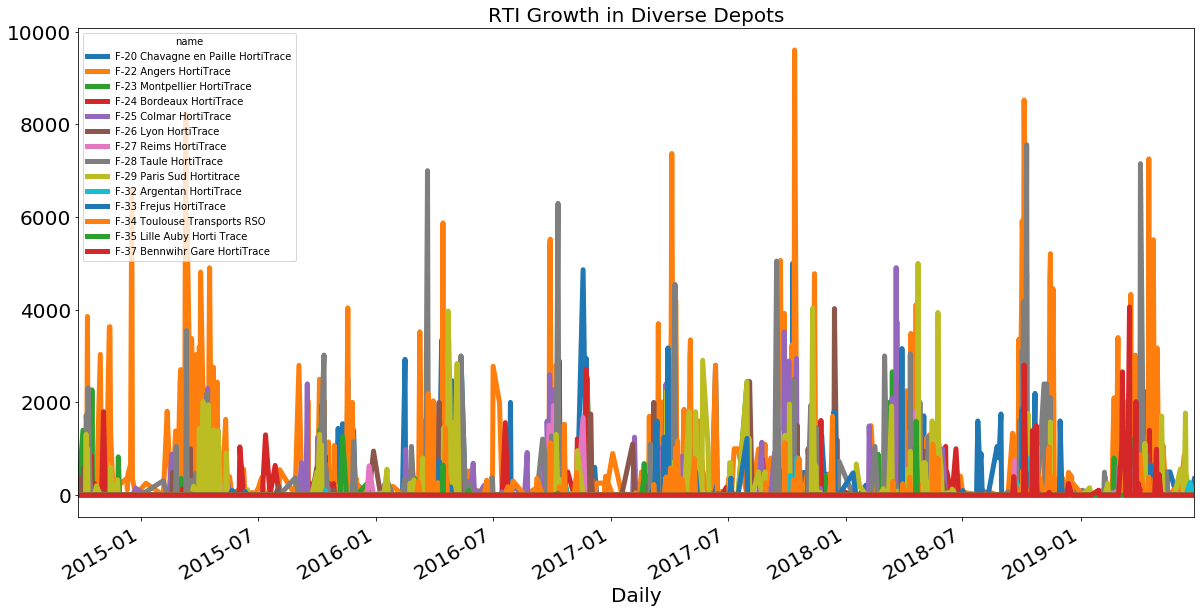

In [46]:
(trans_fr.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY']
   .sum()
   .unstack('name', fill_value=0)
   .plot(figsize=(20,10), linewidth=5, fontsize=20))
plt.title('RTI Growth in Diverse Depots', fontsize=20)
plt.xlabel('Daily', fontsize=20)
plt.show()

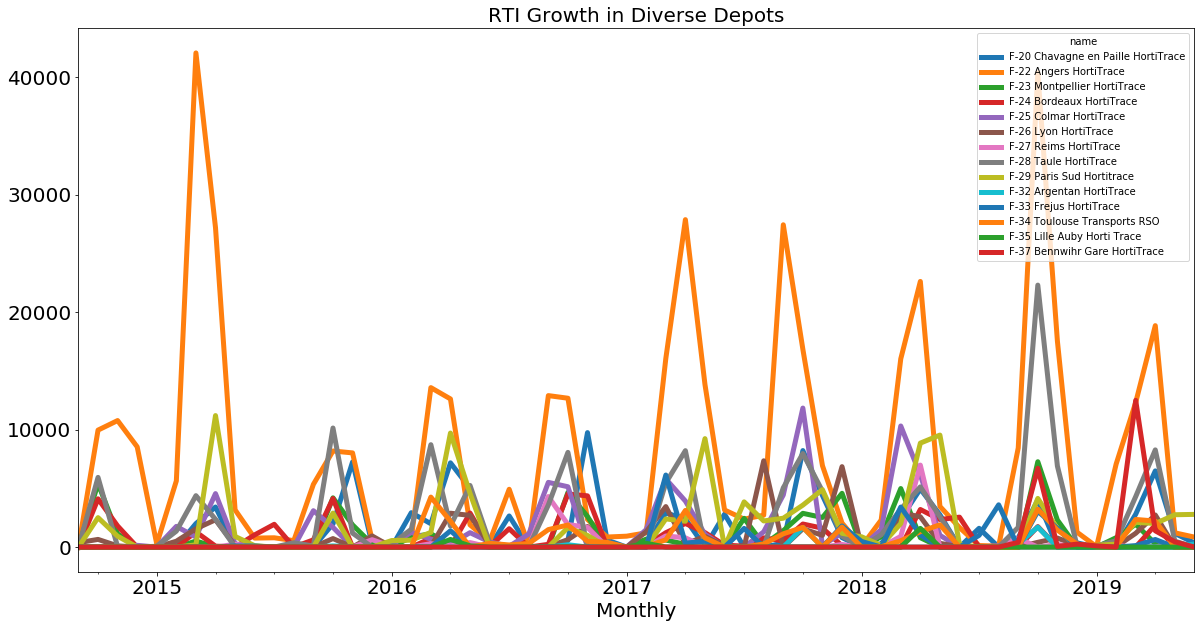

In [47]:
fr_deps = trans_fr.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY'].sum().unstack('name', fill_value=0)
fr_deps_month = fr_deps.resample('1M').sum()
fr_deps_month.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title('RTI Growth in Diverse Depots', fontsize=20)
plt.xlabel('Monthly', fontsize=20)
plt.show()

## From 2017 on

Text(0.5, 1.0, 'CB_FR : Jan 2016--Jul 2019')

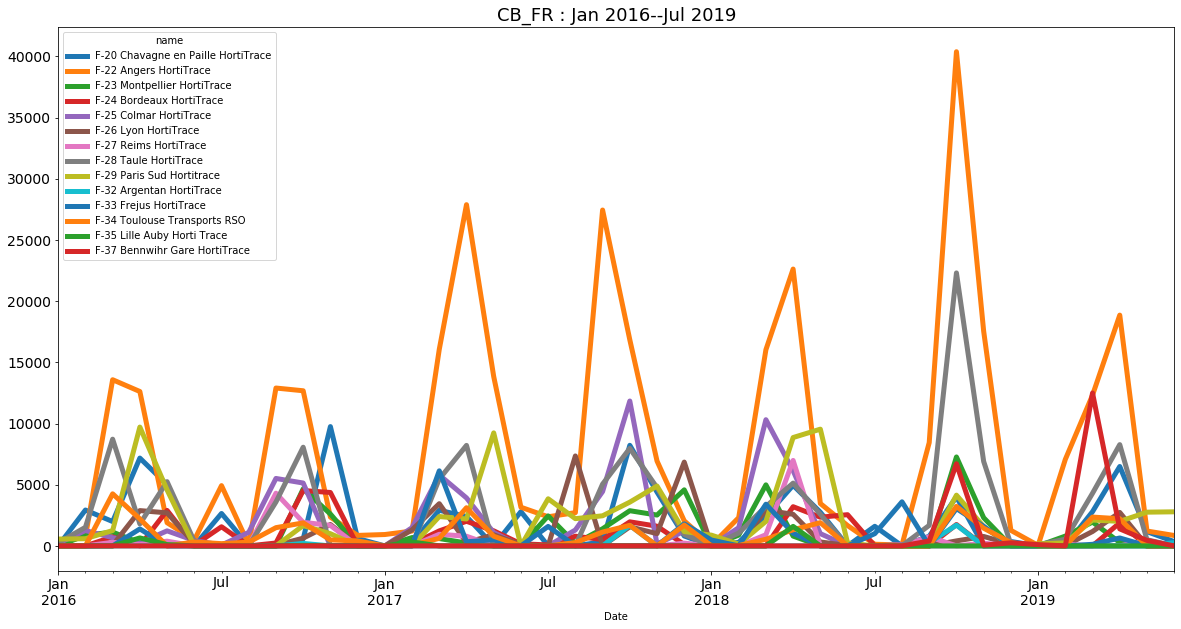

In [48]:
import datetime
fr_cb2016 = fr_deps_month[(it_cbm.index >= datetime.datetime(2016,1,31))]
fr_cb2016.plot(figsize=(20,10), linewidth=5, fontsize=14)
plt.title("CB_FR : Jan 2016--Jul 2019", fontsize = 18)

In [49]:
depos = trans_fr['name'].unique()

In [50]:
def optimal_sarima(depot):
    
    stepwise_model = arima.auto_arima(depot, start_p=1, start_q=1,
                               max_p=3, max_q=3, m=6,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    return stepwise_model
    #print(stepwise_model.aic())

In [51]:
opt_sarima_deps = []
for i in range(0,len(depos)):
    dep = fr_cb2016[[depos[i]]].dropna()
    print('\n ' + depos[i] + ': ')
    print('\n')
    opt_sarima = optimal_sarima(dep)
    print(opt_sarima.aic())
    opt_sarima_deps.append(opt_sarima)


 F-26 Lyon HortiTrace: 


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=642.774, BIC=650.551, Fit time=0.285 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=683.141, BIC=686.251, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=664.103, BIC=670.325, Fit time=0.077 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=640.829, BIC=647.050, Fit time=0.185 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=681.153, BIC=682.708, Fit time=0.007 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 6); AIC=661.367, BIC=667.589, Fit time=0.092 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 1) 

Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=603.314, BIC=612.646, Fit time=0.237 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=611.692, BIC=616.358, Fit time=0.062 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=601.310, BIC=609.087, Fit time=0.182 seconds
Near non-invertible roots for order (0, 1, 2)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=608.760, BIC=616.537, Fit time=0.163 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=608.540, BIC=619.428, Fit time=0.332 seconds
Total fit time: 2.566 seconds
600.1768010524877

 F-28 Taule HortiTrace: 


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=683.664, BIC=691.440, Fit time=0.226 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=712.735, BIC=715.846, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seas

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 6); AIC=656.401, BIC=665.733, Fit time=0.252 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 6); AIC=660.627, BIC=668.404, Fit time=0.225 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 0, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 1, 6); AIC=661.088, BIC=671.975, Fit time=0.400 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 6); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 6); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 6); AIC=661.927, BIC=671.259, Fit time=0.355 seconds
Near non-invertible roots for order (1, 1, 1)(2, 1, 0, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 6); AIC=nan, BIC=nan, 

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=662.636, BIC=673.524, Fit time=0.347 seconds
Near non-invertible roots for order (2, 1, 2)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 2.784 seconds
651.5512727874394

 F-33 Frejus HortiTrace: 


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=623.314, BIC=631.091, Fit time=0.245 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=663.838, BIC=666.949, Fit time=0.007 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=634.097, BIC=640.319, Fit time=0.138 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=621.531, BIC=627.752, Fit time=0.181 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=661.848, BIC=663.403, 

Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=518.401, BIC=526.178, Fit time=0.289 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=562.051, BIC=568.272, Fit time=0.021 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 6); AIC=520.285, BIC=529.617, Fit time=0.360 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 1, 6); AIC=520.309, BIC=529.641, Fit time=0.285 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=538.180, BIC=545.957, Fit time=0.132 seconds
Near non-invertible roots for order (2, 1, 0)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 1, 6); AIC=522.225, BIC=533.112, Fit time=0.430 seconds
Near non-invertible roots for order (2, 1, 0)(2, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(3, 1, 0) seasonal_order=(1, 1, 0, 6)

Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=515.353, BIC=524.685, Fit time=0.306 seconds
Near non-invertible roots for order (2, 1, 1)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=515.348, BIC=524.680, Fit time=0.333 seconds
Near non-invertible roots for order (1, 1, 2)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=528.030, BIC=532.696, Fit time=0.073 seconds
Near non-invertible roots for order (0, 1, 0)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=513.317, BIC=521.093, Fit time=0.243 seconds
Near non-invertible roots for order (0, 1, 2)(0, 1, 1, 6); setting score to inf (at least one inverse root

In [52]:
opt_sarima_deps[0]

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 1, 6),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [53]:
d1 = fr_cb2016[[depos[1]]].dropna()
train1 = d1.loc['2016-01-31':'2018-12-31']
test1 = d1.loc['2019-01-31':]


In [54]:
dep1_fit = opt_sarima_deps[1].fit(train1)

In [55]:
dep1_forecast = dep1_fit.predict(n_periods=6)
dep1_forecast

array([1547.45926418, 1541.81434425, 2974.37467761,  371.31683275,
       1286.03752794, 1903.3370041 ])

Text(0.5, 1.0, '2019 Prediction of F-23 Montpellier HortiTrace')

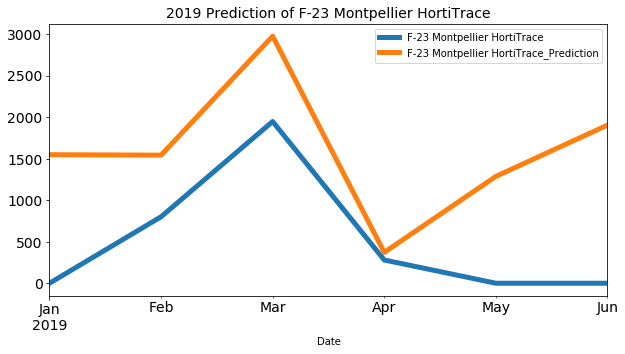

In [56]:
dep1_forecast = pd.DataFrame(dep1_forecast,index = test.index,columns=[depos[1] + '_Prediction'])
pd.concat([test1,dep1_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=14)
plt.title('2019 Prediction of ' + depos[1], fontsize = 14)

In [57]:
for j in range(0,len(depos)):
    d = fr_cb2016[[depos[i]]].dropna()
    

    print(d.index)

DatetimeIndex(['2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30'],
              dtype='datetime64[ns]', name='Date', freq='M')
DatetimeIndex(['2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', 

In [58]:
optimal_test = list()
optimal_prediction = list()
opt_deps_forecast = list()
depo_train = list()
depo_test = list()
mse = list()

for f in range(0, len(depos)):
    dep = fr_cb2016[[depos[f]]].dropna()
    my_train = dep.loc['2016-01-31':'2018-12-31']
    my_test = dep.loc['2019-01-31':]
    
    model_fit = opt_sarima_deps[f].fit(my_train)

    depo_forecast = model_fit.predict(n_periods=6)
    
    for col in range(len(depo_forecast)):
        if depo_forecast[col] < 0:
            depo_forecast[col] = 0
    
    opt_deps_forecast.append(depo_forecast)
    depo_train.append(my_train)
    depo_test.append(my_test)
    



In [59]:
depo_test

[name        F-26 Lyon HortiTrace
 Date                            
 2019-01-31                     0
 2019-02-28                    30
 2019-03-31                  1176
 2019-04-30                  2735
 2019-05-31                     0
 2019-06-30                     0, name        F-23 Montpellier HortiTrace
 Date                                   
 2019-01-31                            0
 2019-02-28                          800
 2019-03-31                         1947
 2019-04-30                          280
 2019-05-31                            0
 2019-06-30                            0, name        F-24 Bordeaux HortiTrace
 Date                                
 2019-01-31                         0
 2019-02-28                         0
 2019-03-31                         0
 2019-04-30                      1885
 2019-05-31                         0
 2019-06-30                         0, name        F-28 Taule HortiTrace
 Date                             
 2019-01-31               

In [60]:
opt_deps_forecast

[array([  0.        , 142.20321629,   0.        ,   0.        ,
          0.        ,   0.        ]),
 array([1547.45926418, 1541.81434425, 2974.37467761,  371.31683275,
        1286.03752794, 1903.3370041 ]),
 array([   0.        ,    0.        ,    0.        , 1022.3424127 ,
         767.93630748,    0.        ]),
 array([ 1585.42495504,  2278.03539175,  4305.48873531, 13835.48685834,
         6153.46950603,  1939.4263781 ]),
 array([ 1125.50625178,  1480.03918834, 12858.72377019, 33052.11736988,
        12857.37685864,  1572.54204107]),
 array([   0.        ,    0.        ,    0.        , 2560.35203512,
        2458.38211223,    0.        ]),
 array([   0.        ,    0.        , 1616.21439525, 1364.47858207,
           0.        ,    0.        ]),
 array([   0.        ,    0.        ,   34.75050316, 2660.27337874,
        1734.37380291,    0.        ]),
 array([1370.98484989, 1478.32514897, 2365.29627176, 1827.29336148,
        1282.08209373, 1280.78481858]),
 array([   0.        ,

In [61]:
depots_forecasts = pd.DataFrame()

In [62]:
for i in range(0, len(depos)):
    depots_forecasts[depos[i]] = opt_deps_forecast[i]
    

In [63]:
my_test

name,F-37 Bennwihr Gare HortiTrace
Date,
2019-01-31,105
2019-02-28,0
2019-03-31,12495
2019-04-30,1388
2019-05-31,448
2019-06-30,0


In [64]:
depots_forecasts['Date'] = my_test.index
depots_forecasts = depots_forecasts.set_index('Date')
depots_forecasts

,F-26 Lyon HortiTrace,F-23 Montpellier HortiTrace,F-24 Bordeaux HortiTrace,F-28 Taule HortiTrace,F-22 Angers HortiTrace,F-29 Paris Sud Hortitrace,F-25 Colmar HortiTrace,F-20 Chavagne en Paille HortiTrace,F-33 Frejus HortiTrace,F-27 Reims HortiTrace,F-32 Argentan HortiTrace,F-34 Toulouse Transports RSO,F-35 Lille Auby Horti Trace,F-37 Bennwihr Gare HortiTrace
Date,,,,,,,,,,,,,,
2019-01-31,0.000000,1547.459264,0.000000,1585.424955,1125.506252,0.000000,0.000000,0.000000,1370.984850,0.000000,79.076766,1.953294,25.916649,892.849428
2019-02-28,142.203216,1541.814344,0.000000,2278.035392,1480.039188,0.000000,0.000000,0.000000,1478.325149,0.000000,79.530690,319.802519,80.846237,903.698174
2019-03-31,0.000000,2974.374678,0.000000,4305.488735,12858.723770,0.000000,1616.214395,34.750503,2365.296272,799.612743,117.533712,783.851154,35.317872,1344.167991
2019-04-30,0.000000,371.316833,1022.342413,13835.486858,33052.117370,2560.352035,1364.478582,2660.273379,1827.293361,1159.149875,316.858784,2721.418734,407.189393,7693.245098
2019-05-31,0.000000,1286.037528,767.936307,6153.469506,12857.376859,2458.382112,0.000000,1734.373803,1282.082094,0.000000,80.892462,1545.495734,57.936902,1082.387687
2019-06-30,0.000000,1903.337004,0.000000,1939.426378,1572.542041,0.000000,0.000000,0.000000,1280.784819,0.000000,81.346387,708.485399,40.413234,1313.527197


In [65]:
def plot_depo_prediction(depo_name, depo_test, depo_pred):
        pd.concat([depo_test, depo_pred], axis=1).plot(figsize=(10,5), linewidth=5, fontsize=14)
        plt.title('2019 Prediction of ' + depo_name, fontsize = 14)        

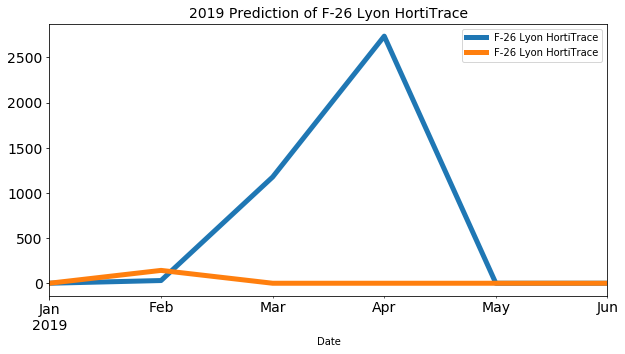

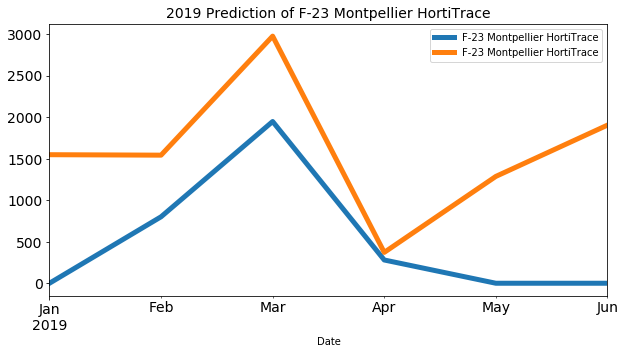

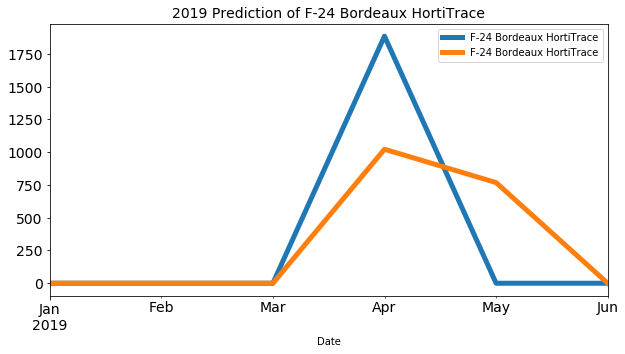

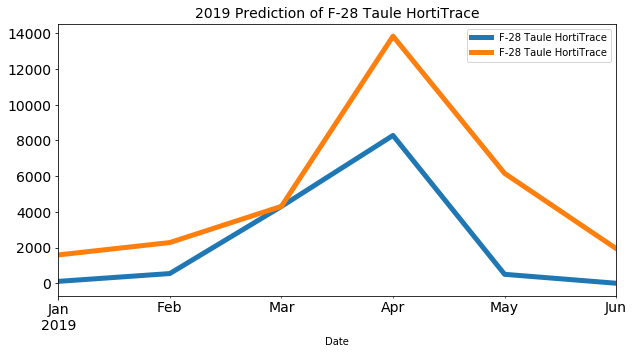

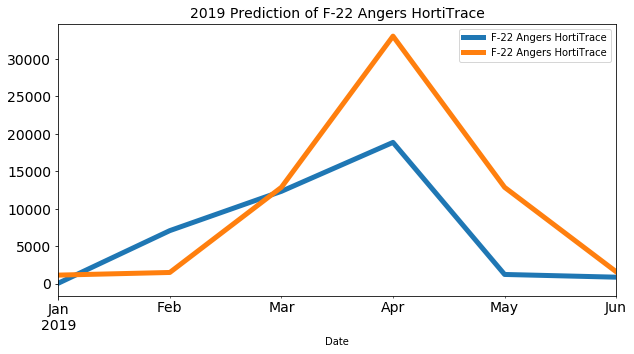

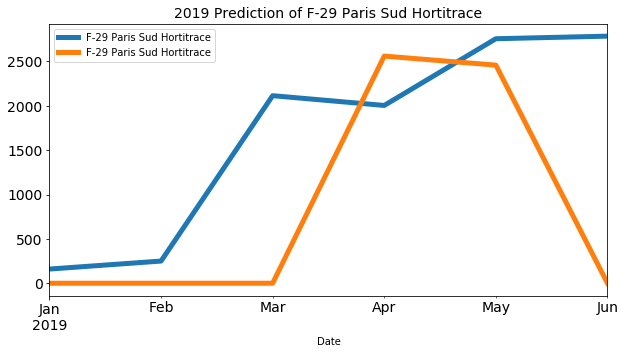

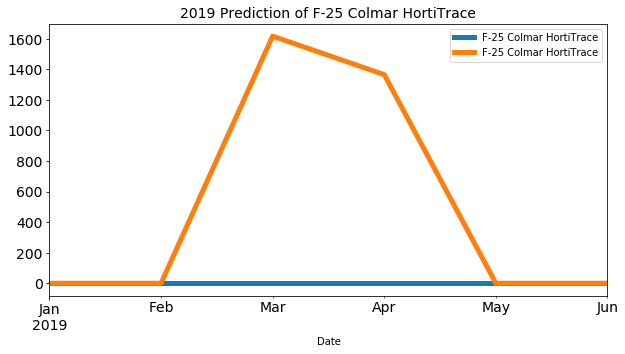

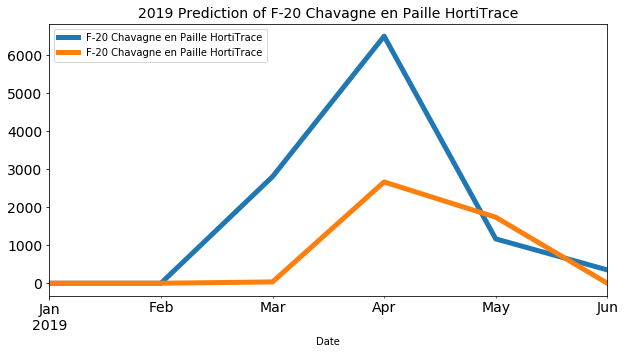

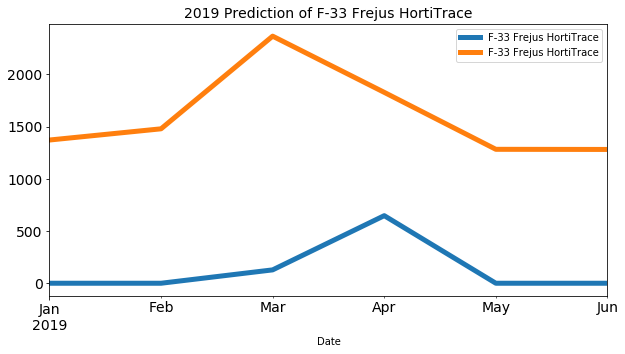

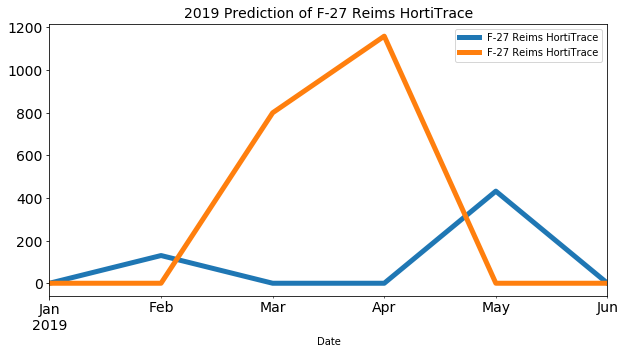

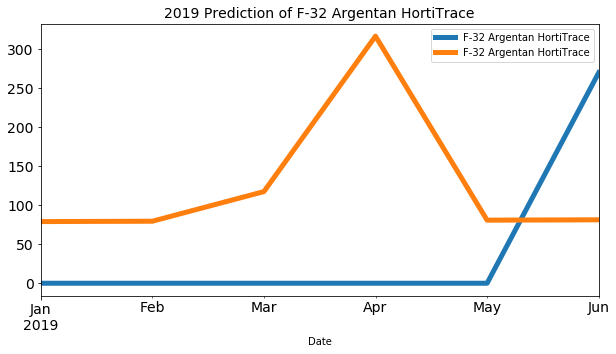

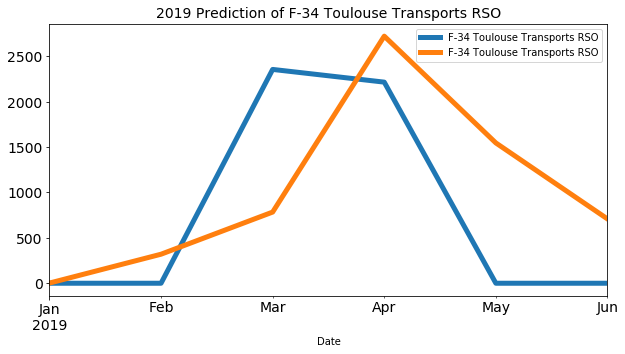

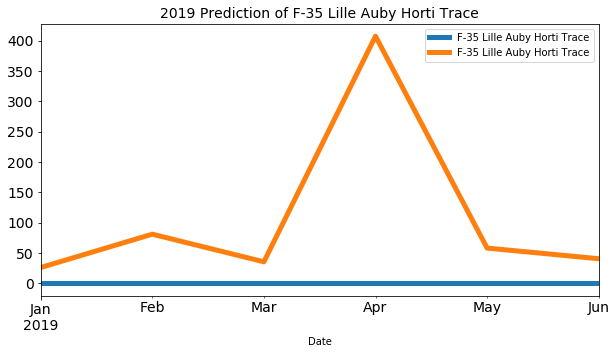

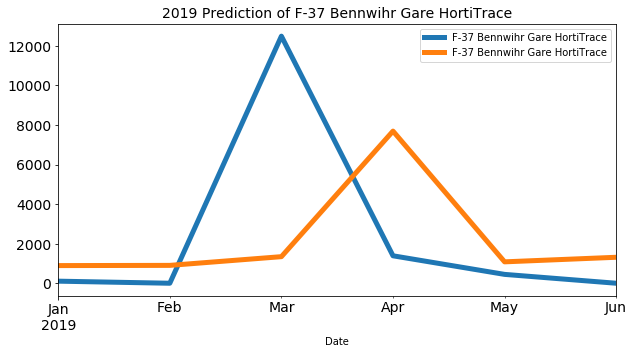

In [66]:
depos_mse = list()
for j in range(0, len(depos)):
    plot_depo_prediction(depos[j], depo_test[j], depots_forecasts[[depos[j]]])
    mse = mean_squared_error(depo_test[j], depots_forecasts[[depos[j]]])
    depos_mse.append(mse)

In [67]:
depos_mse

[1479298.4269577619,
 1547556.743699628,
 222317.38087750645,
 11970894.227266433,
 61711023.12763899,
 2118570.8323505246,
 745658.4620526601,
 3792073.141264886,
 2291295.996340932,
 364422.1619842206,
 28154.28407809539,
 952959.1197941256,
 29874.70910948204,
 27943724.79828341]

In [68]:
norm = [i/sum(depos_mse) for i in depos_mse]
norm

[0.012841374803332743,
 0.013433906109223149,
 0.0019298748387196482,
 0.10391597577746209,
 0.5356960860891757,
 0.018390719282768826,
 0.0064728520033559625,
 0.0329179235245845,
 0.01989009799388488,
 0.003163446592925926,
 0.0002443994447488514,
 0.008272370879685822,
 0.0002593339719858646,
 0.24257163868814596]

In [69]:
print('Normalized MSE of depots: ')
for r in range(0, len(depos)):
    print('\n ' + depos[r] + ' : ' + str(norm[r]))

i = norm.index(min(norm))
print('\n the MOST accurate : ' + depos[i])

j = norm.index(max(norm))
print('\n the LEAST accurate: ' + depos[j])

Normalized MSE of depots: 

 F-26 Lyon HortiTrace : 0.012841374803332743

 F-23 Montpellier HortiTrace : 0.013433906109223149

 F-24 Bordeaux HortiTrace : 0.0019298748387196482

 F-28 Taule HortiTrace : 0.10391597577746209

 F-22 Angers HortiTrace : 0.5356960860891757

 F-29 Paris Sud Hortitrace : 0.018390719282768826

 F-25 Colmar HortiTrace : 0.0064728520033559625

 F-20 Chavagne en Paille HortiTrace : 0.0329179235245845

 F-33 Frejus HortiTrace : 0.01989009799388488

 F-27 Reims HortiTrace : 0.003163446592925926

 F-32 Argentan HortiTrace : 0.0002443994447488514

 F-34 Toulouse Transports RSO : 0.008272370879685822

 F-35 Lille Auby Horti Trace : 0.0002593339719858646

 F-37 Bennwihr Gare HortiTrace : 0.24257163868814596

 the MOST accurate : F-32 Argentan HortiTrace

 the LEAST accurate: F-22 Angers HortiTrace


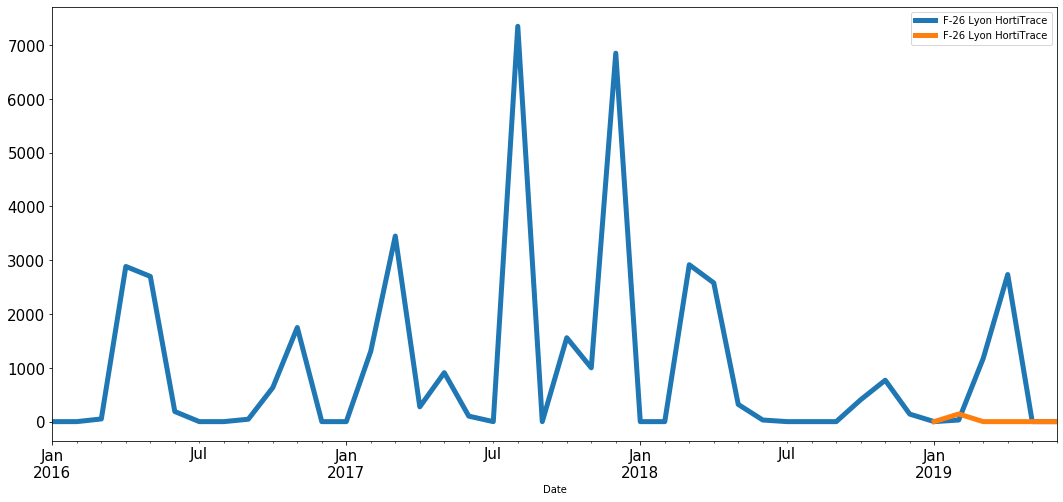

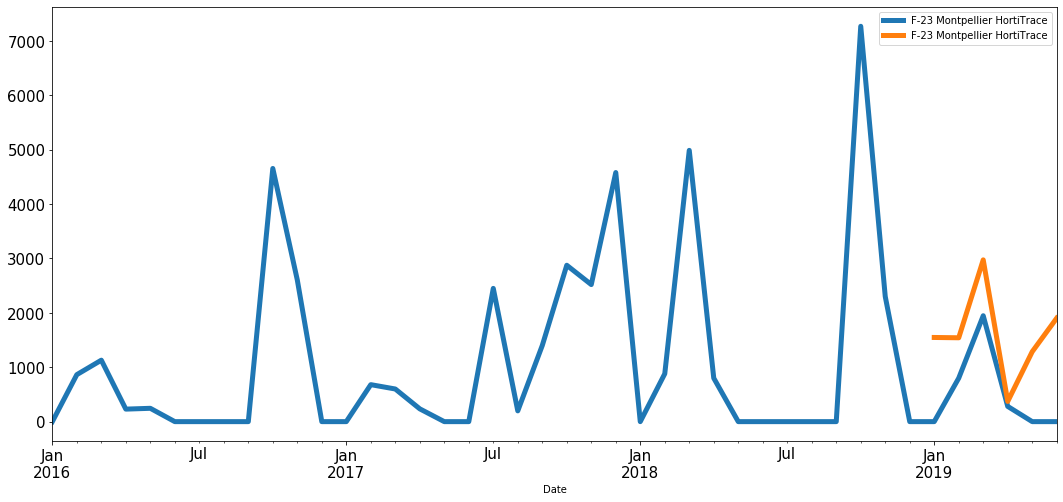

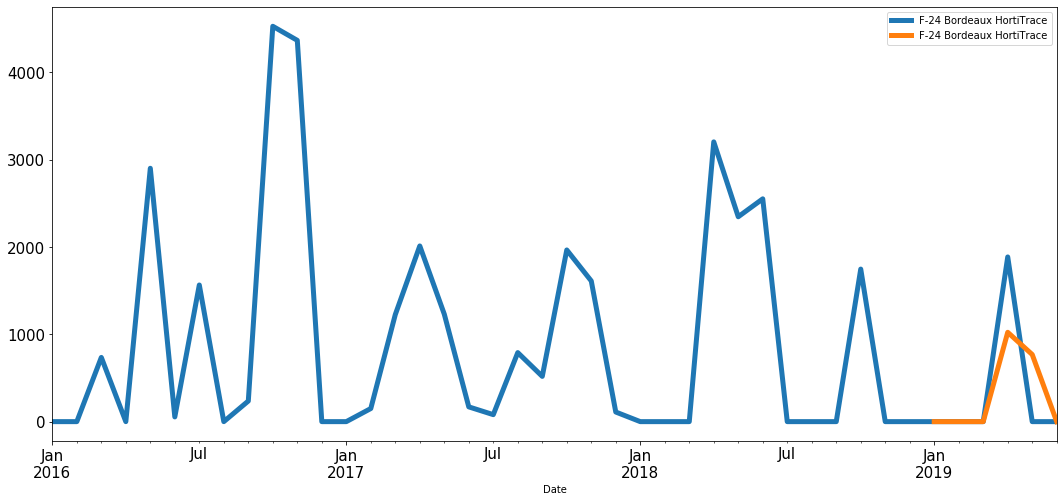

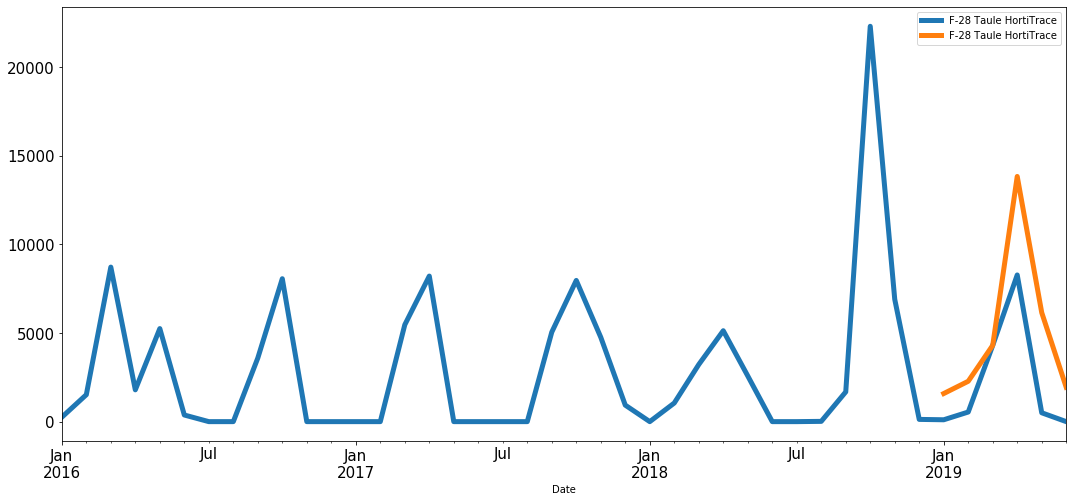

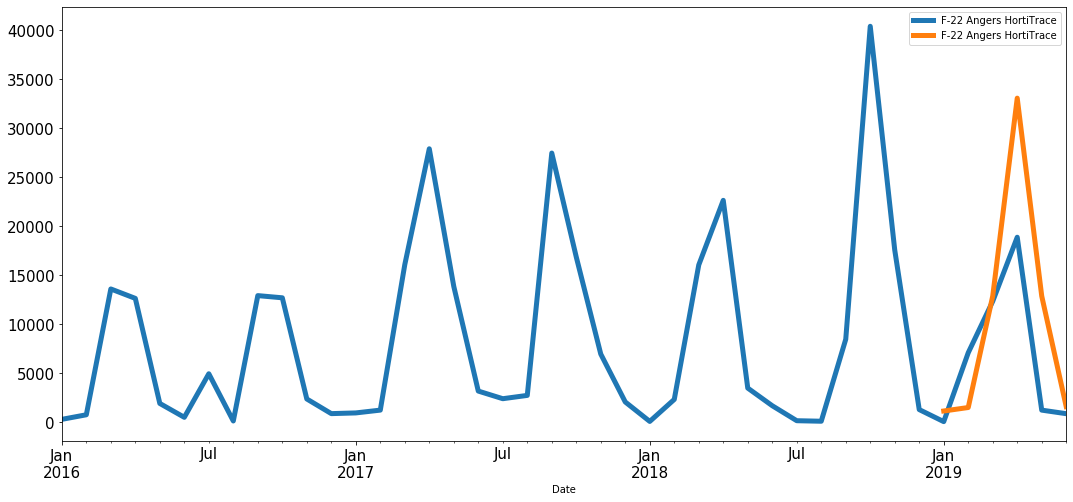

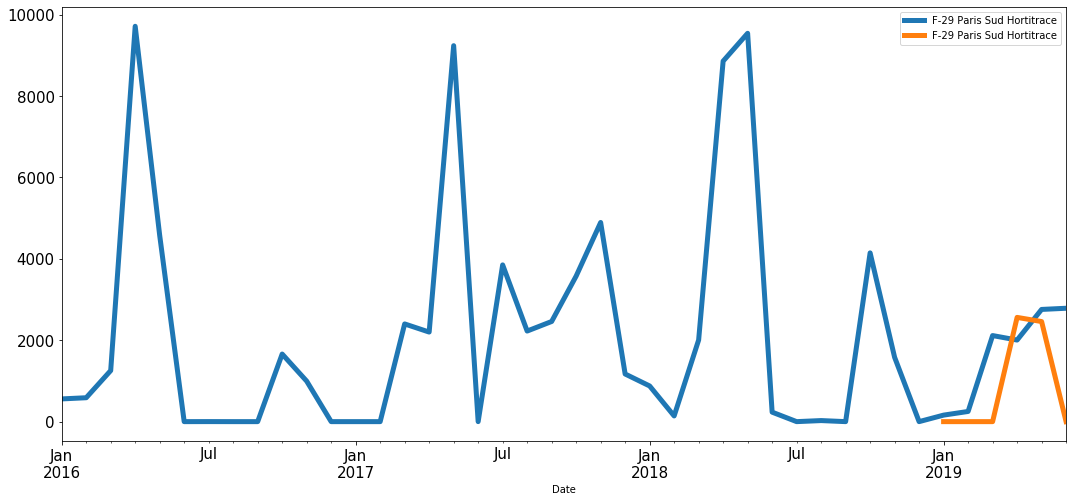

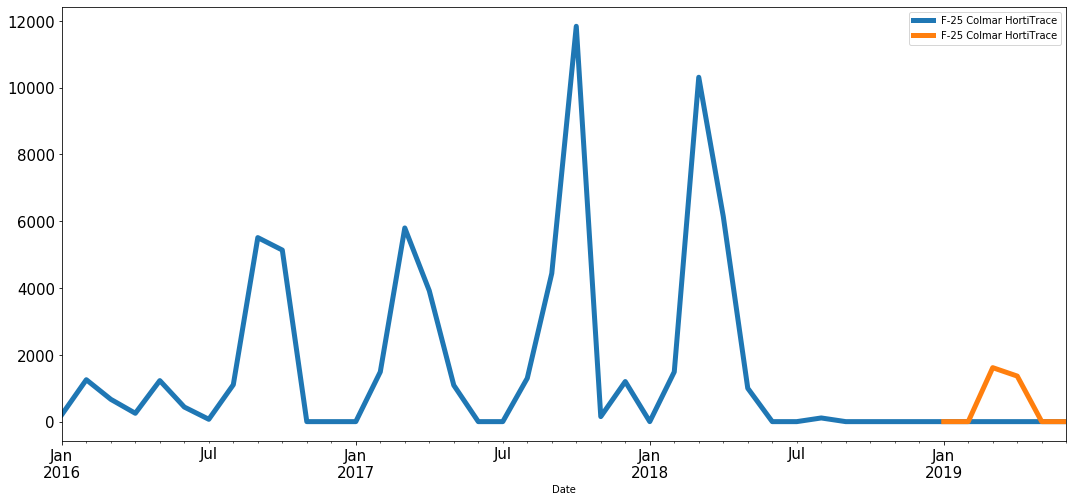

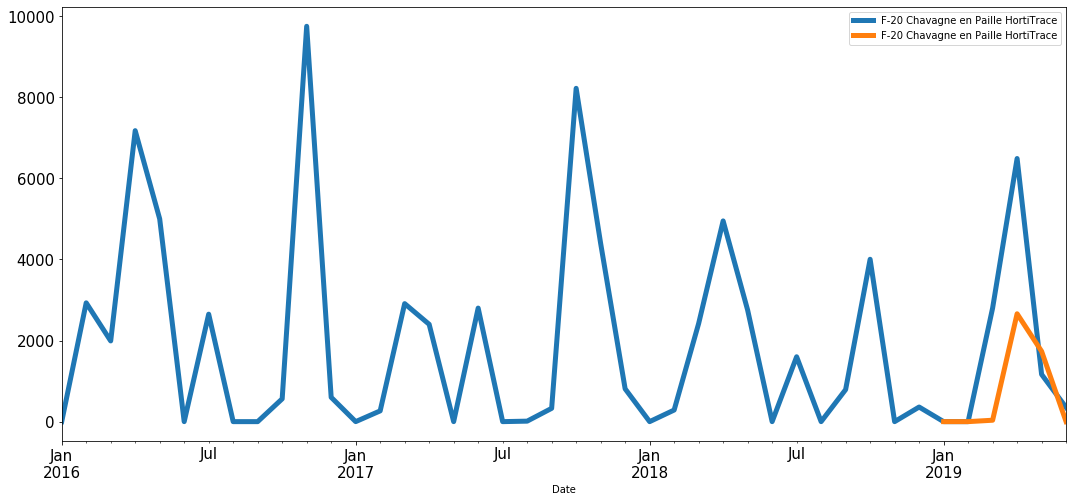

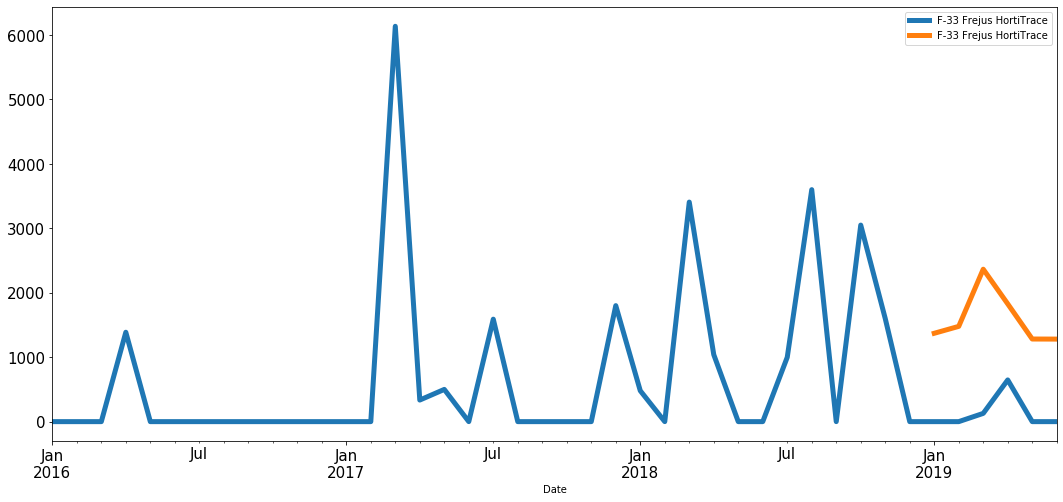

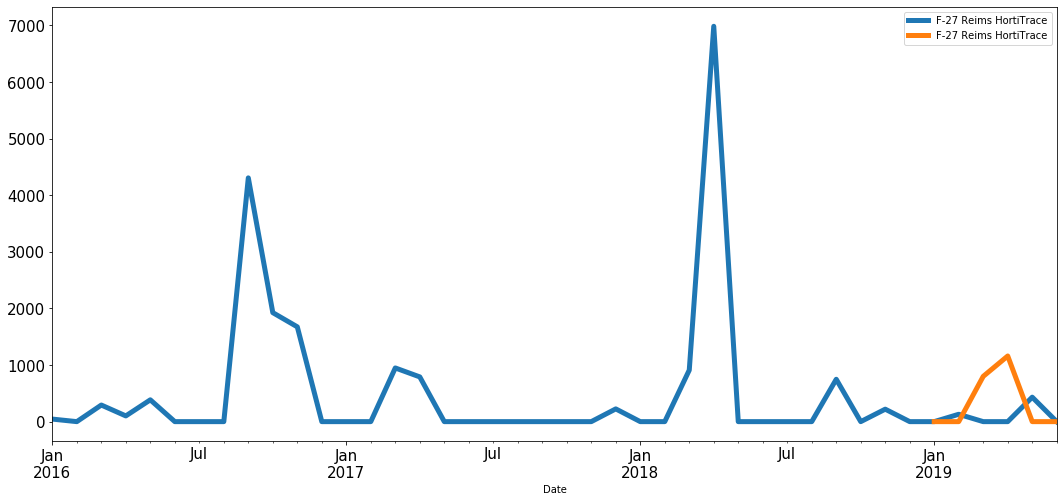

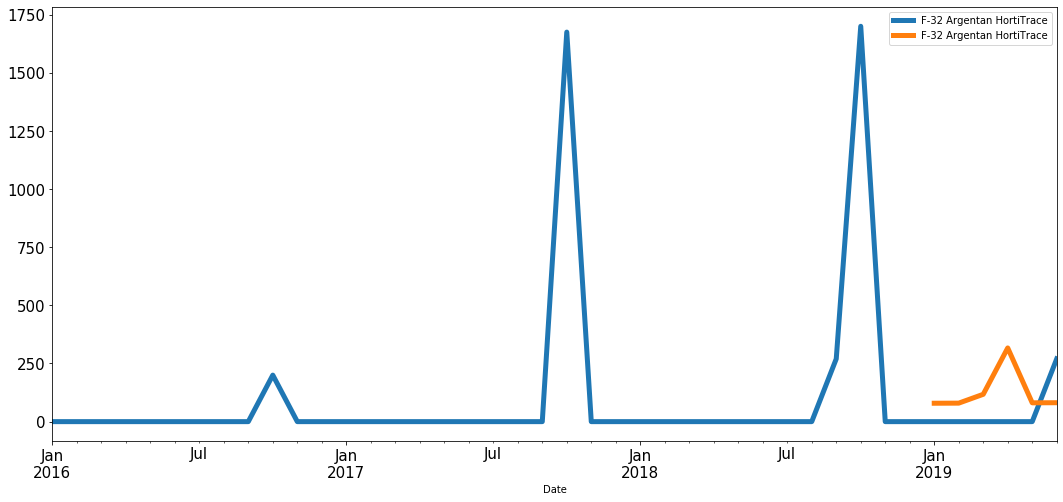

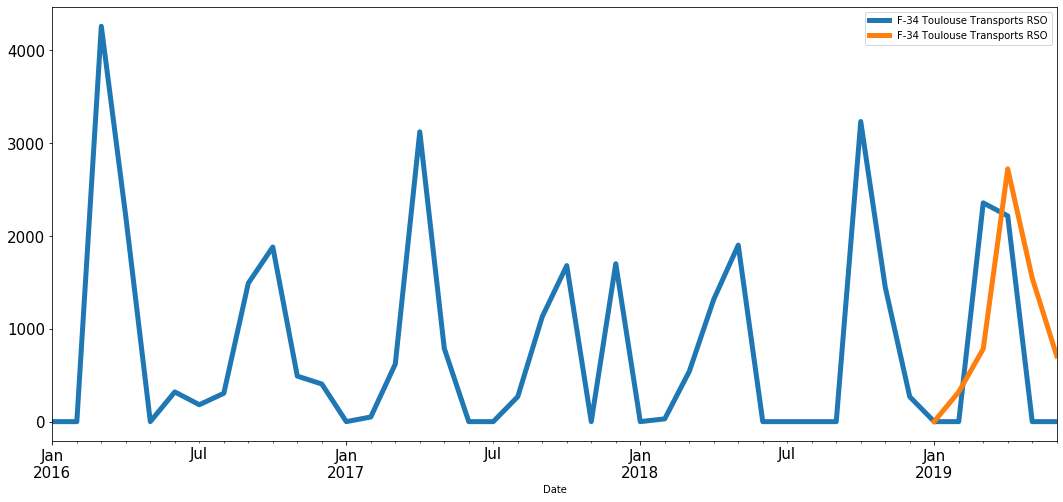

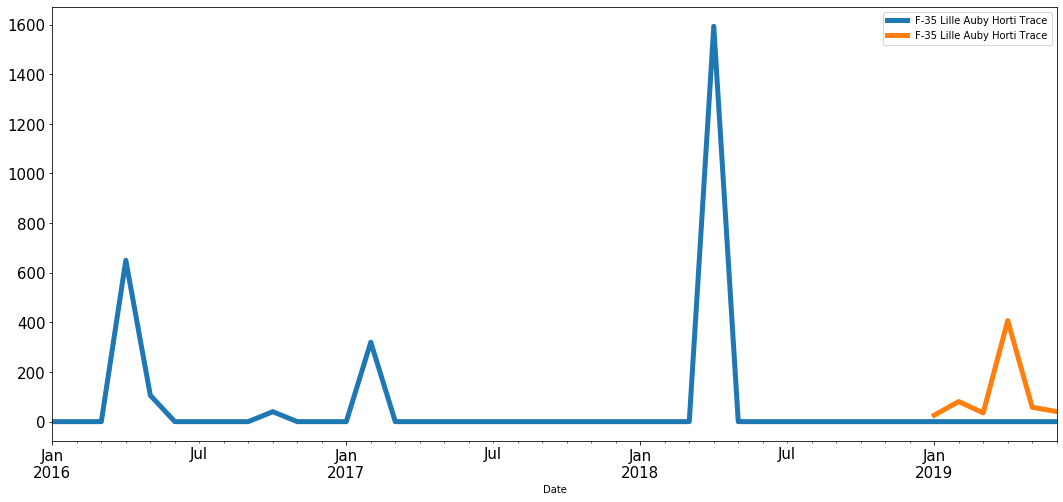

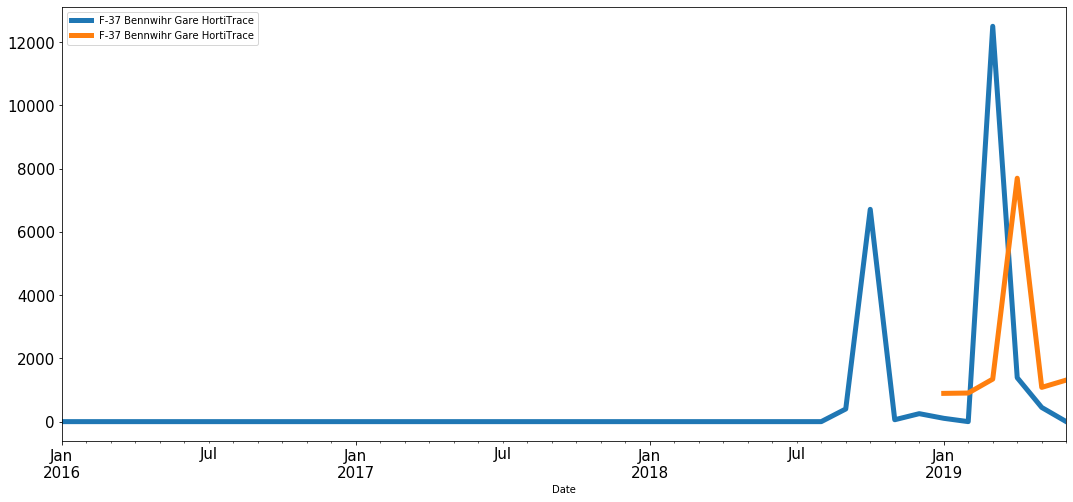

In [70]:
for s in range(0, len(depos)):
    pd.concat([fr_cb2016[[depos[s]]], depots_forecasts[[depos[s]]]],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)

### Summation is NOT a good idea for France:

In [71]:
depots_forecasts['france'] = depots_forecasts.sum(axis=1)
#depots_forecasts

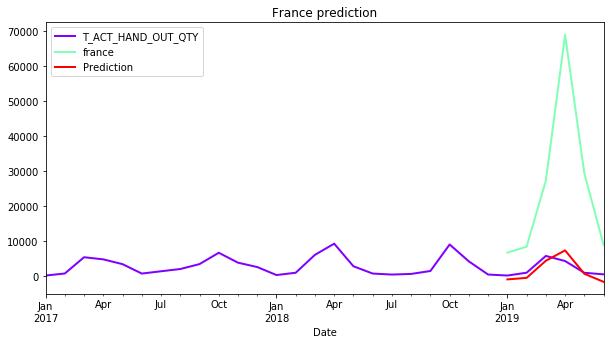

In [72]:
pd.concat([it_cb_m, depots_forecasts['france'], future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='France prediction')

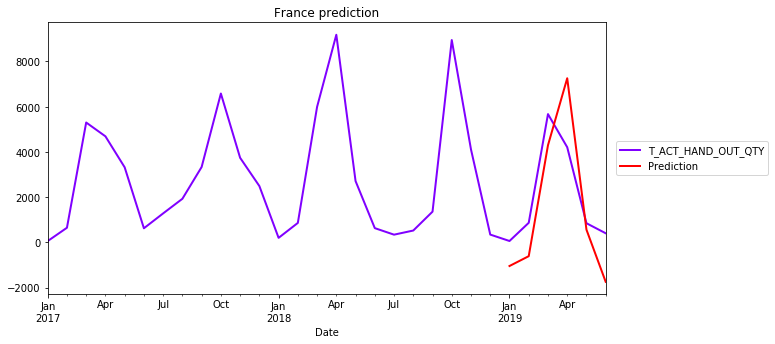

In [73]:
#pd.concat([it_cb_m, depots_forecasts['france'], future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='France prediction')
pd.concat([it_cb_m, future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='France prediction')
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.show()

In [74]:
#future_forecast

In [75]:
for col in future_forecast:
    future_forecast[col][future_forecast[col] < 0] = 0

In [76]:
#future_forecast

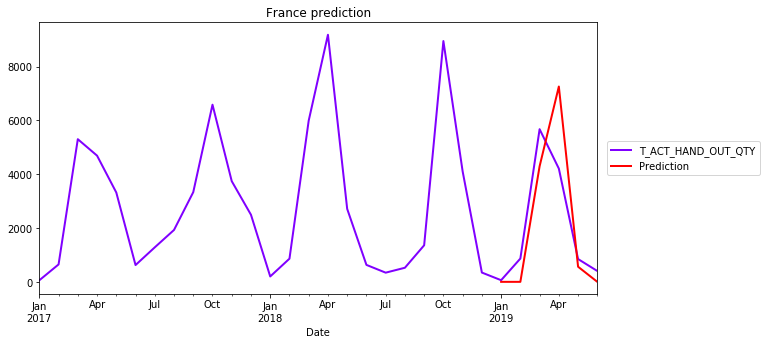

In [77]:
pd.concat([it_cb_m, future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='France prediction')
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.show()

In [78]:
depots_forecasts = depots_forecasts.drop('france', axis = 1)

In [79]:
depots_forecasts['total'] = future_forecast

In [80]:
depots_forecasts

,F-26 Lyon HortiTrace,F-23 Montpellier HortiTrace,F-24 Bordeaux HortiTrace,F-28 Taule HortiTrace,F-22 Angers HortiTrace,F-29 Paris Sud Hortitrace,F-25 Colmar HortiTrace,F-20 Chavagne en Paille HortiTrace,F-33 Frejus HortiTrace,F-27 Reims HortiTrace,F-32 Argentan HortiTrace,F-34 Toulouse Transports RSO,F-35 Lille Auby Horti Trace,F-37 Bennwihr Gare HortiTrace,total
Date,,,,,,,,,,,,,,,
2019-01-31,0.000000,1547.459264,0.000000,1585.424955,1125.506252,0.000000,0.000000,0.000000,1370.984850,0.000000,79.076766,1.953294,25.916649,892.849428,0.000000
2019-02-28,142.203216,1541.814344,0.000000,2278.035392,1480.039188,0.000000,0.000000,0.000000,1478.325149,0.000000,79.530690,319.802519,80.846237,903.698174,0.000000
2019-03-31,0.000000,2974.374678,0.000000,4305.488735,12858.723770,0.000000,1616.214395,34.750503,2365.296272,799.612743,117.533712,783.851154,35.317872,1344.167991,4294.873146
2019-04-30,0.000000,371.316833,1022.342413,13835.486858,33052.117370,2560.352035,1364.478582,2660.273379,1827.293361,1159.149875,316.858784,2721.418734,407.189393,7693.245098,7258.786447
2019-05-31,0.000000,1286.037528,767.936307,6153.469506,12857.376859,2458.382112,0.000000,1734.373803,1282.082094,0.000000,80.892462,1545.495734,57.936902,1082.387687,561.699749
2019-06-30,0.000000,1903.337004,0.000000,1939.426378,1572.542041,0.000000,0.000000,0.000000,1280.784819,0.000000,81.346387,708.485399,40.413234,1313.527197,0.000000


In [81]:
depots_forecasts['sum(ExceptLyon)'] = depots_forecasts.drop('F-26 Lyon HortiTrace', axis=1).sum(axis=1)
depots_forecasts

,F-26 Lyon HortiTrace,F-23 Montpellier HortiTrace,F-24 Bordeaux HortiTrace,F-28 Taule HortiTrace,F-22 Angers HortiTrace,F-29 Paris Sud Hortitrace,F-25 Colmar HortiTrace,F-20 Chavagne en Paille HortiTrace,F-33 Frejus HortiTrace,F-27 Reims HortiTrace,F-32 Argentan HortiTrace,F-34 Toulouse Transports RSO,F-35 Lille Auby Horti Trace,F-37 Bennwihr Gare HortiTrace,total,sum(ExceptLyon)
Date,,,,,,,,,,,,,,,,
2019-01-31,0.000000,1547.459264,0.000000,1585.424955,1125.506252,0.000000,0.000000,0.000000,1370.984850,0.000000,79.076766,1.953294,25.916649,892.849428,0.000000,6629.171459
2019-02-28,142.203216,1541.814344,0.000000,2278.035392,1480.039188,0.000000,0.000000,0.000000,1478.325149,0.000000,79.530690,319.802519,80.846237,903.698174,0.000000,8162.091693
2019-03-31,0.000000,2974.374678,0.000000,4305.488735,12858.723770,0.000000,1616.214395,34.750503,2365.296272,799.612743,117.533712,783.851154,35.317872,1344.167991,4294.873146,31530.204971
2019-04-30,0.000000,371.316833,1022.342413,13835.486858,33052.117370,2560.352035,1364.478582,2660.273379,1827.293361,1159.149875,316.858784,2721.418734,407.189393,7693.245098,7258.786447,76250.309162
2019-05-31,0.000000,1286.037528,767.936307,6153.469506,12857.376859,2458.382112,0.000000,1734.373803,1282.082094,0.000000,80.892462,1545.495734,57.936902,1082.387687,561.699749,29868.070742
2019-06-30,0.000000,1903.337004,0.000000,1939.426378,1572.542041,0.000000,0.000000,0.000000,1280.784819,0.000000,81.346387,708.485399,40.413234,1313.527197,0.000000,8839.862458


In [82]:
depots_forecasts['Lyon_reprediction'] = depots_forecasts['total'] - depots_forecasts['sum(ExceptLyon)']

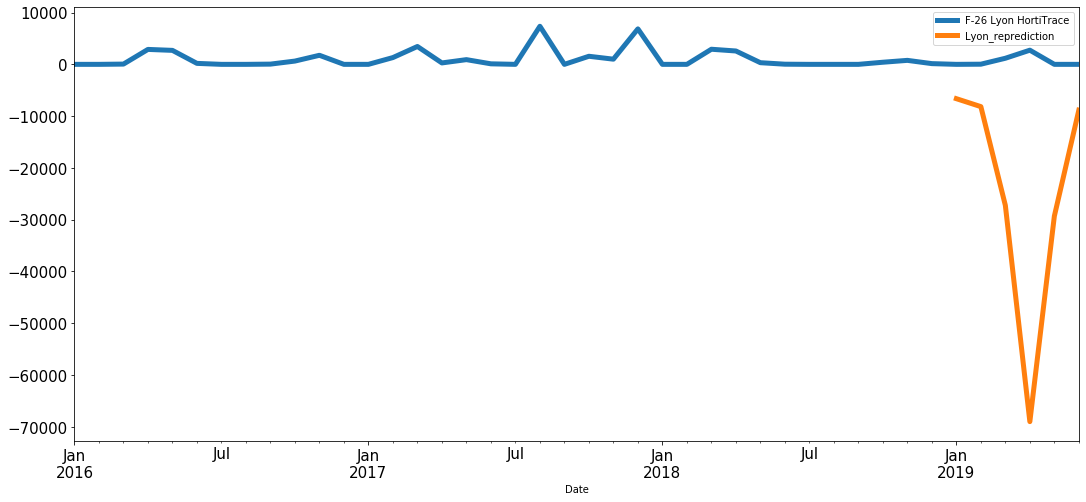

In [83]:
    pd.concat([fr_cb2016[[depos[0]]], depots_forecasts['Lyon_reprediction']],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)